# Lesson 1 - What's your pet

In [1]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [5]:
import os

In [6]:
# help(untar_data)

In [7]:
from fastai.vision import *
from fastai.metrics import fbeta

In [59]:
import torch

In [60]:
torch.__version__

'1.4.0'

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [8]:
# bs = 64
bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

We are going to use the data which features NG and OK two types of `OIL Vessels` . Our model will need to learn to differentiate between these 2 distinct categories. 

In [9]:
path = Path("Images/")

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html).

Set the random seed to two to guarantee that the same validation set is every time. This will give you consistent results with what you see in the lesson video.

In [11]:
# from torch.utils.data import DataLoader, ConcatDataset
# from torchvision.datasets import ImageFolder
# import torchvision.transforms as T

# image_size = 128
# batch_size = 8
# normalization_stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) # Convert channels from [0, 1] to [-1, 1]
# np.random.seed(2)

In [12]:
# normal_dataset = ImageFolder(path, transform=T.Compose([
#     T.Resize(image_size),
#     T.CenterCrop(image_size),
#     T.ToTensor(),
#     T.Normalize(*normalization_stats)]))

# # Augment the dataset with mirrored images
# mirror_dataset = ImageFolder(path, transform=T.Compose([
#     T.Resize(image_size),
#     T.CenterCrop(image_size),
#     T.RandomHorizontalFlip(p=1.0),
#     T.ToTensor(),
#     T.Normalize(*normalization_stats)]))

# # Augment the dataset with color changes
# color_jitter_dataset = ImageFolder(path, transform=T.Compose([
#     T.Resize(image_size),
#     T.CenterCrop(image_size),
#     T.ColorJitter(0.5, 0.5, 0.5),
#     T.ToTensor(),
#     T.Normalize(*normalization_stats)]))

# # Combine the datasets
# dataset_list = [normal_dataset, mirror_dataset, color_jitter_dataset]
# dataset = ConcatDataset(dataset_list)

# device = "cuda" if torch.cuda.is_available() else "cpu"
# kwargs = {'num_workers': 4, 'pin_memory': True} if device=='cuda' else {}
# dataloader = DataLoader(dataset, batch_size, shuffle=True, **kwargs)

In [13]:
# data.add_test

In [14]:
data = ImageDataBunch.from_folder(path, 
                                  ds_tfms=get_transforms(do_flip=True, flip_vert=True, max_rotate=90.0, xtra_tfms = zoom_crop(scale=(1.0,1), do_rand=True)), 
                                  size=224, bs=bs).normalize(imagenet_stats)

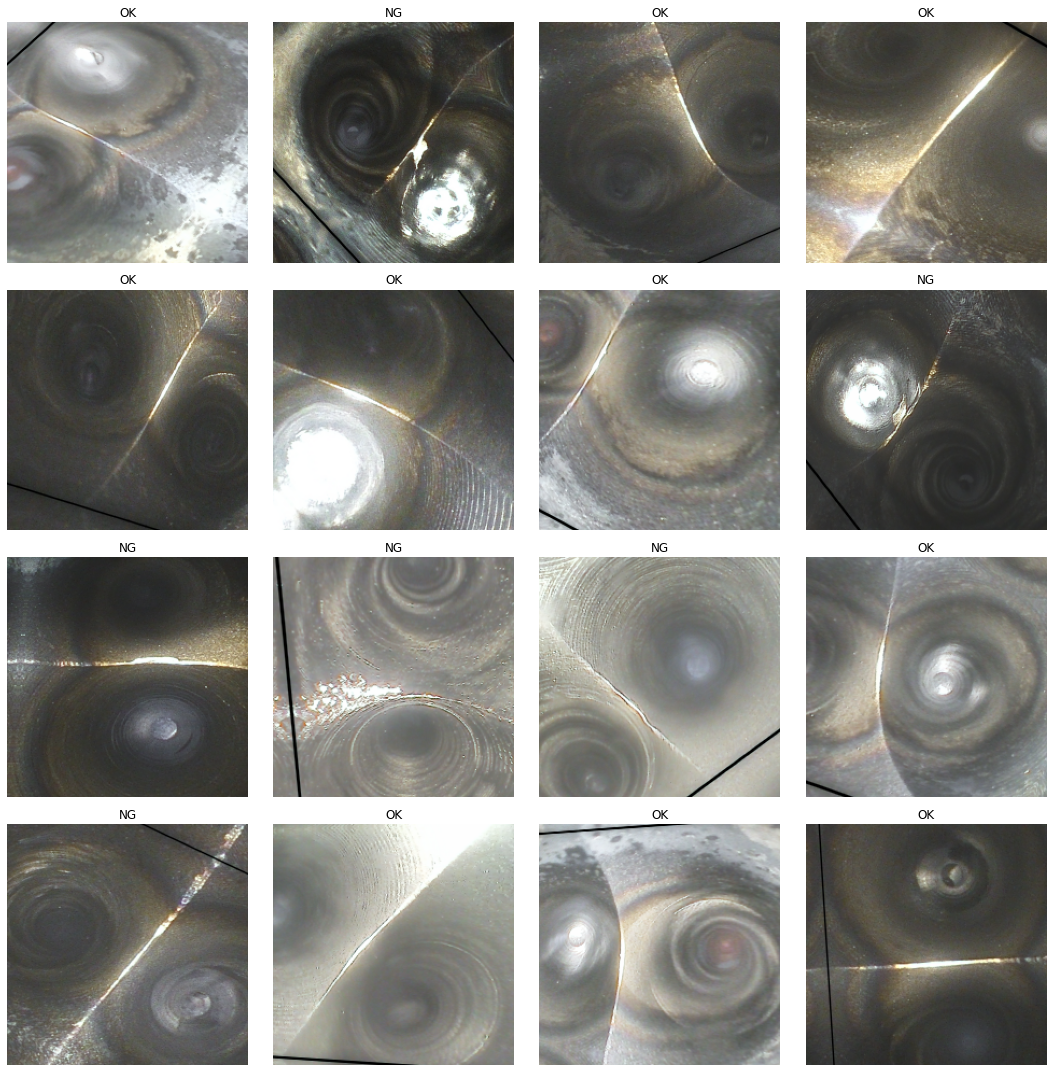

In [15]:
data.show_batch(rows=6, figsize=(15,15))

In [20]:
data.batch_size

16

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [24]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [25]:
learn.model.cuda(device='cuda');

In [26]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.019747,0.816939,0.228571,02:02
1,0.859143,0.583436,0.157143,01:20


In [24]:
# learn.save('stage-1')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [27]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

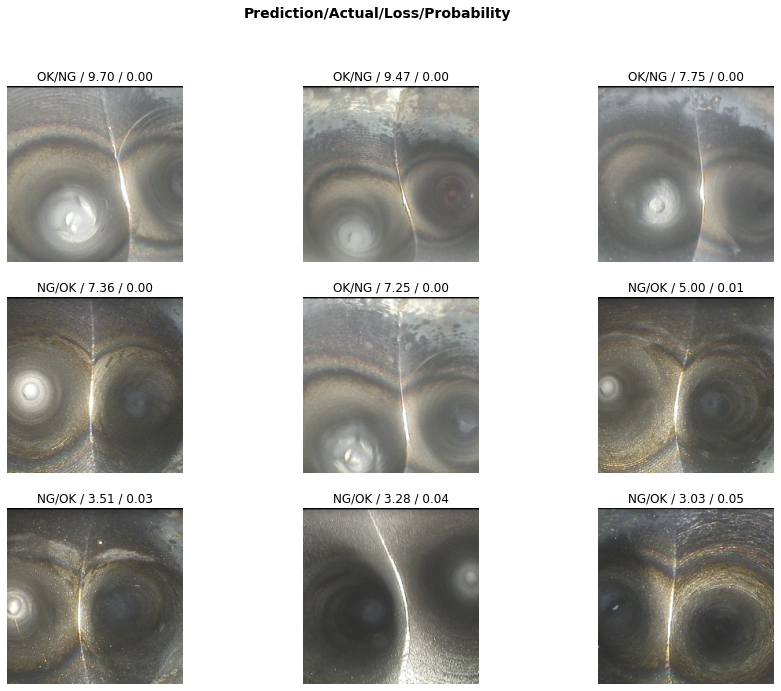

In [28]:
interp.plot_top_losses(9, figsize=(15,11))

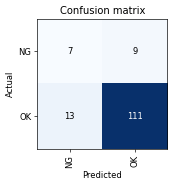

In [29]:
interp.plot_confusion_matrix(figsize=(3,3), dpi=60)

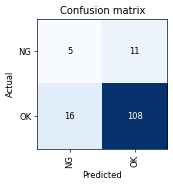

In [29]:
interp.plot_confusion_matrix(figsize=(3,3), dpi=60)

In [29]:
interp.most_confused(min_val=2)

[('NG', 'OK', 24), ('OK', 'NG', 21)]

In [43]:
27/112

0.24107142857142858

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [30]:
learn.unfreeze()

In [31]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,0.705690,0.317979,0.064286,01:25
1,0.630095,1.055044,0.285714,01:20
2,0.656639,0.483826,0.135714,01:22
3,0.586728,0.382280,0.135714,01:20
4,0.520447,0.226192,0.057143,01:19
5,0.455318,0.208292,0.050000,01:20
6,0.391113,0.189755,0.064286,01:21
7,0.336015,0.163123,0.057143,01:19
8,0.280429,0.136174,0.042857,01:22
9,0.235109,0.132934,0.042857,01:23


In [58]:
learn.export()

In [38]:
folder_OK = "Images/train/OK/"
folder_NG = "Images/train/NG/"

In [ ]:
open_image()

In [56]:
###Prediction on NG 

from glob import glob
from IPython.display import clear_output
result = {"OK": 0, "NG": 0}
for path in glob(folder_NG+'/*.jpg'):
    img = open_image(path)
    ret = learn.predict(img)
#     print (ret)
    if str(ret[0]) == "OK":
        result["OK"] += 1
    else:
        result["NG"] += 1
        
    print (result)
    clear_output(wait=True)

{'OK': 15, 'NG': 111}


`When all Are OK : {'OK': 364, 'NG': 5}` <br>
`When all Are NG : {'OK': 15, 'NG': 111}`

That's a pretty accurate model!